In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
housing_original=pd.read_csv("kc_house_data.csv")
housing_original.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### Remove ID and Date
 - Looks like there is no empty / NULL data. 

In [4]:
housing_original=housing_original.drop(['id'],axis=1)
housing_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 20 columns):
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(14), object(1)
memory usage: 3.3+ MB


### Correlation of the features

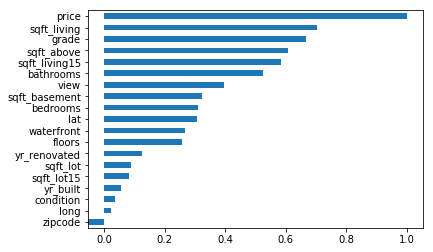

In [5]:
corr_matrix=housing_original.corr()
data1=corr_matrix.price.sort_values(ascending=True)
data1.plot.barh()
plt.show()

### Plot the histogram of all the features
- Categorical:
    - bathrooms
    - bedrooms
    - condition
    - floors
    - grade
    - view
    - waterfront
    - yr_renovated

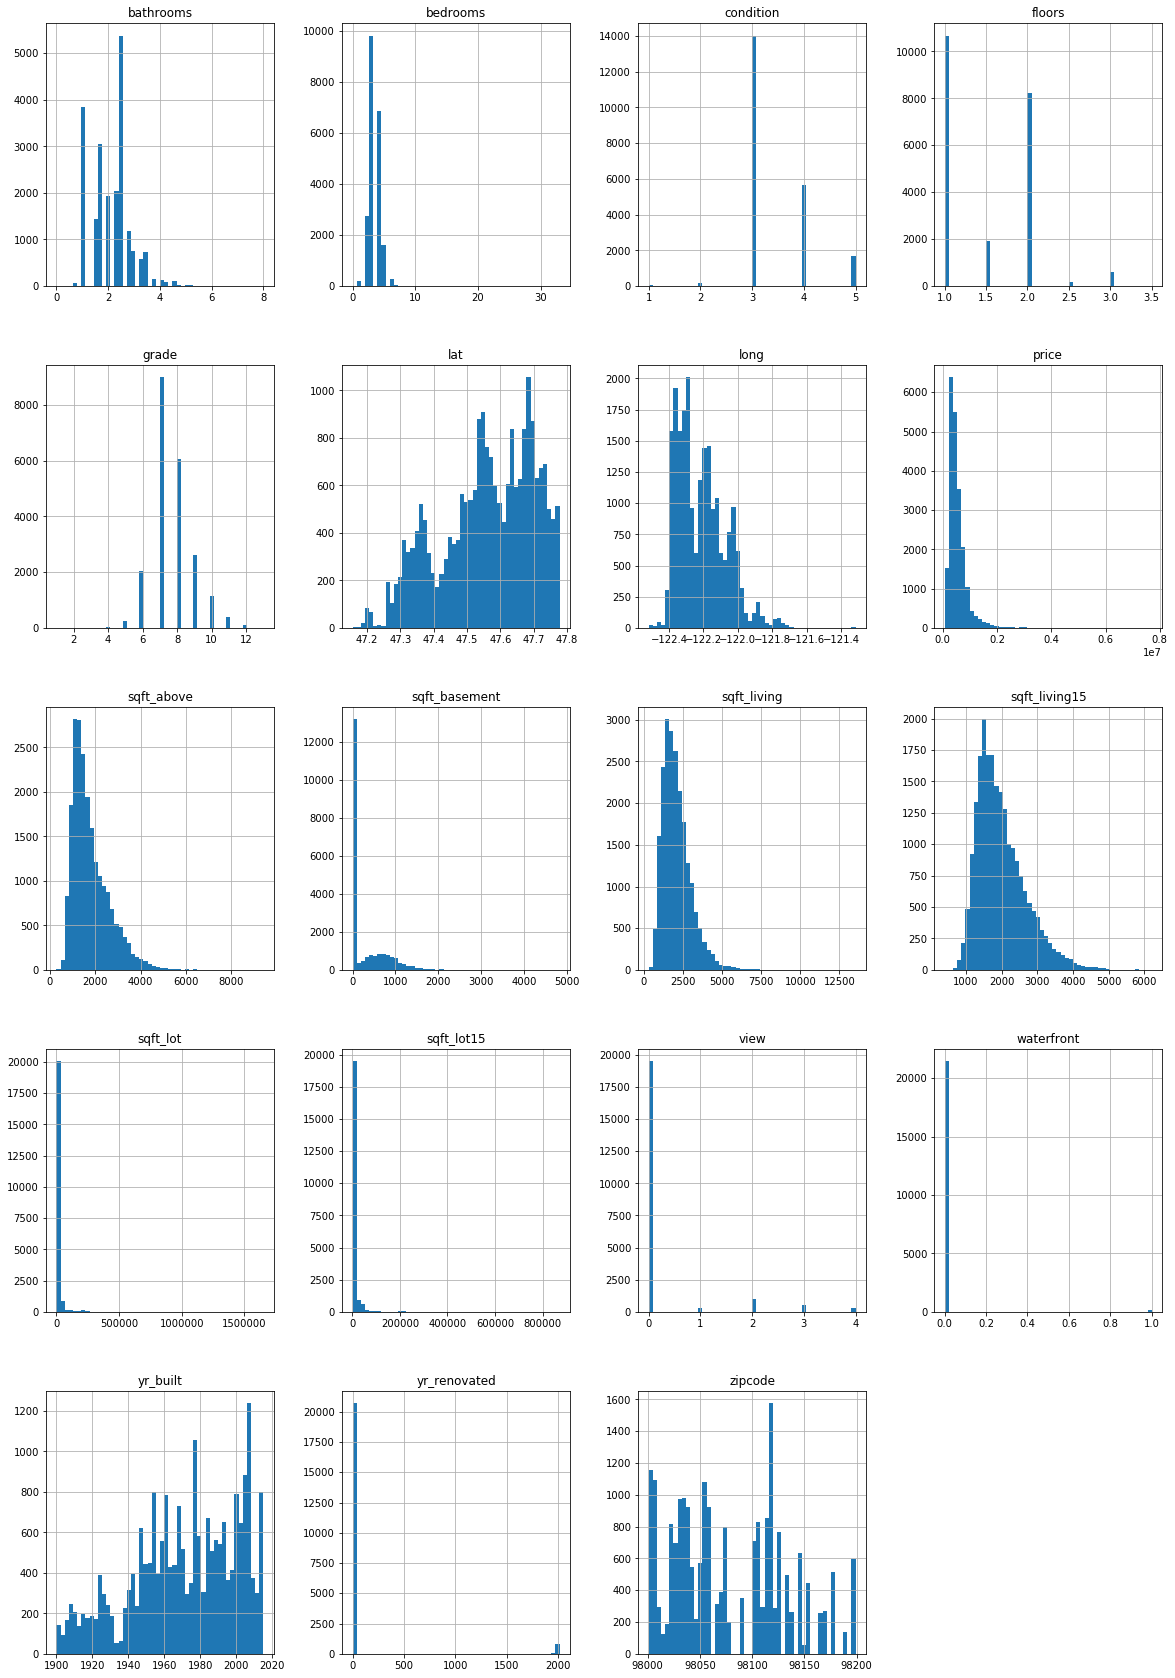

In [6]:
%matplotlib inline
housing_original.hist(bins=50,figsize=(20,30))
plt.show()

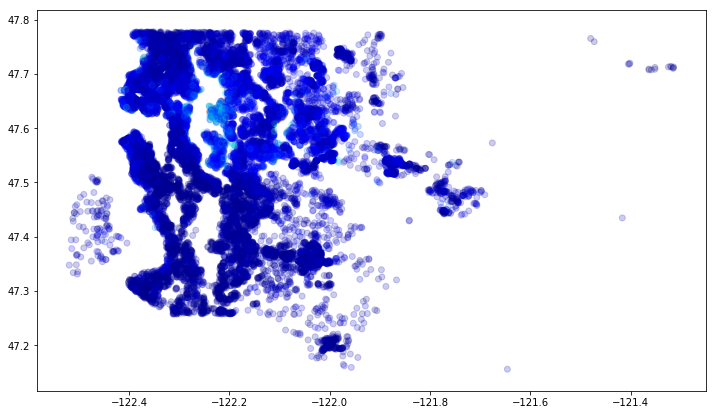

In [7]:
plt.figure(figsize=(12,7))
plt.scatter(housing_original.long,housing_original.lat,alpha=.2,cmap=plt.get_cmap("jet"),c=housing_original.price)
plt.show()

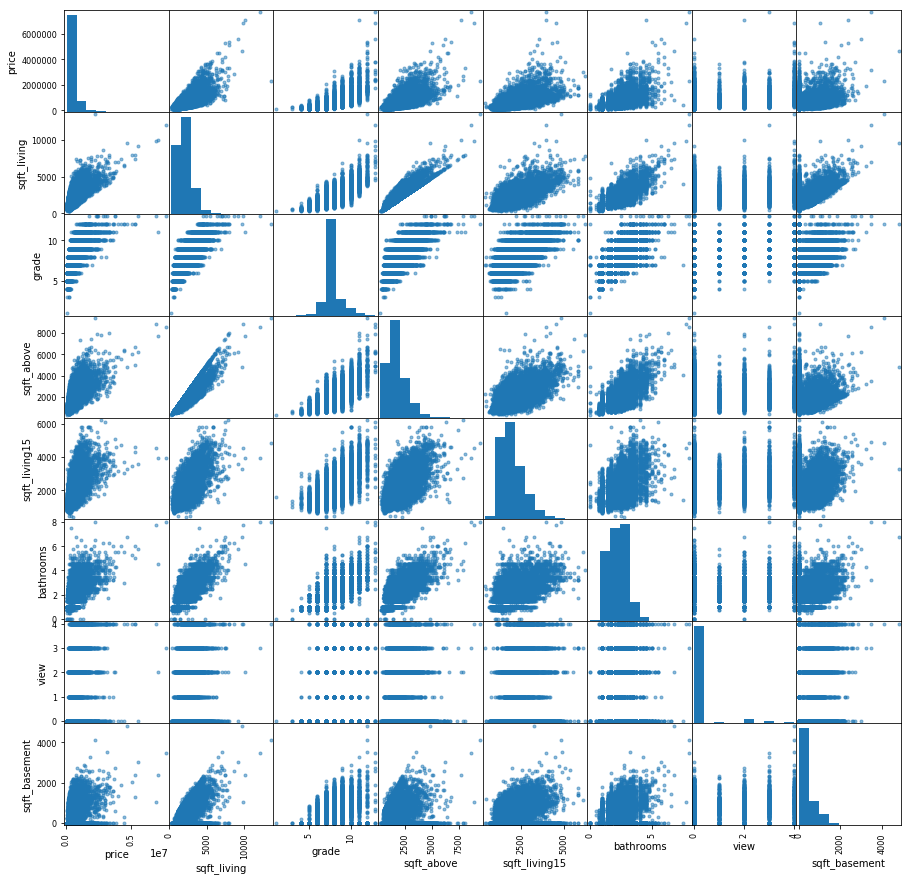

In [8]:
from pandas.tools.plotting import scatter_matrix

attrib=["price","sqft_living", "grade", "sqft_above",
              "sqft_living15","bathrooms","view","sqft_basement"]

scatter_matrix(housing_original[attrib],figsize=(15,15))
plt.show()

### Create Train & Test Data Set

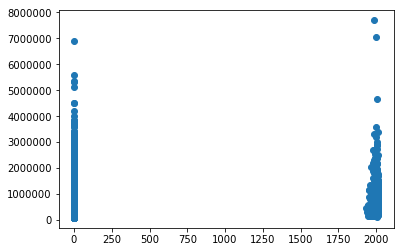

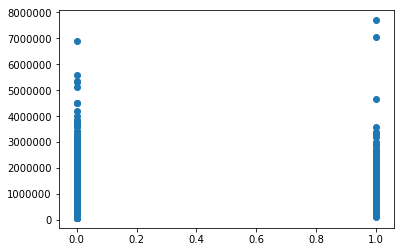

In [9]:
plt.scatter(housing_original.yr_renovated,housing_original.price)
plt.show()
housing_original["renovated"]=housing_original['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
plt.scatter(housing_original.renovated,housing_original.price)
plt.show()




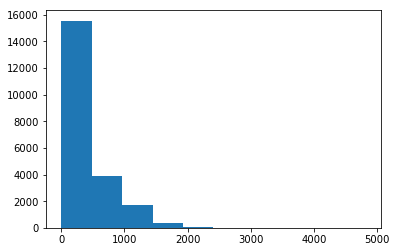

In [10]:

plt.hist(housing_original.sqft_basement)
plt.show()

housing_original["has_basement"]=housing_original.sqft_basement.apply(lambda x: 1 if x > 0 else 0)


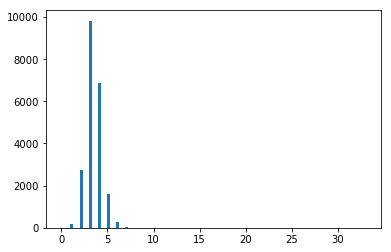

F:\ProgramData\Anaconda3\envs\36\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


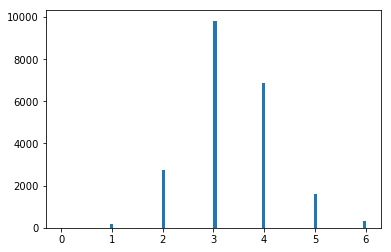

In [11]:
plt.hist(housing_original.bedrooms,bins=100)
plt.show()

housing_original.bedrooms[housing_original.bedrooms>6]=6
plt.hist(housing_original.bedrooms,bins=100)
plt.show()



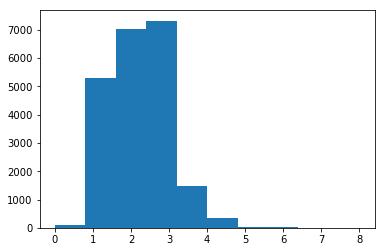

F:\ProgramData\Anaconda3\envs\36\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


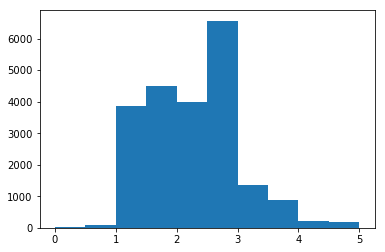

In [12]:
#plt.figure(figsize=(12,5))
plt.hist(housing_original.bathrooms)
plt.show()

housing_original.bathrooms[housing_original.bathrooms>5]=5
plt.hist(housing_original.bathrooms)
plt.show()


In [13]:


housing_original['Year'] = housing_original['date'].str[:4]
housing_original['Year']=housing_original.Year.astype('int')
housing_original=housing_original.drop('date',axis=1)


In [14]:
housing_original['yrs_since_renovated'] = (housing_original['Year'] - housing_original['yr_renovated'][housing_original['yr_renovated'] != 0]).fillna(0)
housing_original=housing_original.drop("yr_renovated",axis=1)


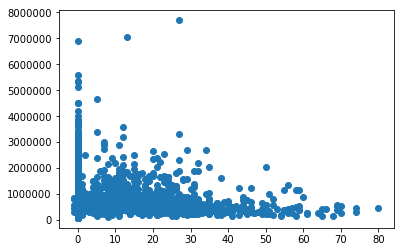

In [15]:
plt.scatter(housing_original.yrs_since_renovated,housing_original.price)


In [16]:
housing_original["total_sqft"]=housing_original.sqft_above+housing_original.sqft_basement+housing_original.sqft_lot


In [17]:
#plt.scatter(housing_original.total_sqft,housing_original.price)
#housing_original.total_sqft.hist(bins=50)


In [18]:
housing_original=housing_original.drop("sqft_lot15",axis=1)
housing_original=housing_original.drop("sqft_lot",axis=1)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

#from sklearn.cross_validation import StratifiedShuffleSplit

#dummies = pd.get_dummies(housing_original.floors, drop_first=False)
#dummies = dummies.add_prefix("{}#".format('floors'))
#housing_original.drop('floors', axis=1, inplace=True)
#housing_original = housing_original.join(dummies)




In [20]:
import numpy as np
#housing_original['price_range']=np.ceil(housing_original['price']/100000)
#housing_original['price_range'].where(housing_original['price_range'] < 11, 11, inplace=True)
#housing_original['price_range'].hist(bins=100,figsize=(12,5))

#housing_original['grade_2']=housing_original['grade']*housing_original['grade']
#housing_original.head()



# Initial Prediction

### Create the pipeline

In [21]:
import sklearn.pipeline as pipeline
import sklearn.preprocessing as pp


from sklearn.base import BaseEstimator,TransformerMixin
class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names=attribute_names
    
    def fit(self,X,y=None):
        return self;
    
    def transform(self,X):
        return X[self.attribute_names].values


housing_X=housing_original.drop(['price'],axis=1)
housing_y=housing_original.price.as_matrix()


#cat_cols=['condition','grade','view','floors#1.0','floors#1.5','floors#2.0','floors#2.5','floors#3.0','floors#3.5']
#cat_cols=['condition','grade','sqft_basement','yrs_since_renovated','view','total_sqft']
cat_col1=['condition']
cat_col2=['grade']
cat_col3=['view']
cat_col4=['zipcode']

cat_cols=[]
contd_cols=list(housing_X.drop(cat_cols,axis=1))


contd_pipe=pipeline.Pipeline([
    ('DataFrameSelector',DataFrameSelector(list(contd_cols))),
    ('std_scaler',pp.StandardScaler())
])

cat_pipe1=pipeline.Pipeline([
    ('DataFrameSelector',DataFrameSelector(cat_col1)),
    ('label_binarizer',pp.LabelBinarizer())
])
cat_pipe2=pipeline.Pipeline([
    ('DataFrameSelector',DataFrameSelector(cat_col2)),
    ('label_binarizer',pp.LabelBinarizer())
])

cat_pipe3=pipeline.Pipeline([
    ('DataFrameSelector',DataFrameSelector(cat_col3)),
    ('label_binarizer',pp.LabelBinarizer())
])

cat_pipe4=pipeline.Pipeline([
    ('DataFrameSelector',DataFrameSelector(cat_col4)),
    ('label_binarizer',pp.LabelBinarizer())
])

full_pipeline=pipeline.FeatureUnion(transformer_list=[
    ("contd_pipe",contd_pipe),
    ("cat_pipe1",cat_pipe1),
    ("cat_pipe2",cat_pipe2),
    ("cat_pipe3",cat_pipe3),
    ("cat_pipe4",cat_pipe4),

])

housing_tr_X=full_pipeline.fit_transform(housing_X)

housing=pd.DataFrame(housing_tr_X)

X_train, X_test, y_train, y_test=train_test_split(housing_tr_X
                                                      ,housing_y,test_size=.3,random_state=40
                                                  ,stratify=None)


#for set in (X_train_p, X_test_p):
#    set.drop(["price_range"], axis=1, inplace=True)    


housing.head()




,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
0,-0.410536,-1.460884,-0.979835,-0.915427,-0.087173,-0.305759,-0.629187,-0.558836,-0.734708,-0.658681,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.410536,0.179788,0.533634,0.936506,-0.087173,-0.305759,-0.629187,-0.558836,0.460841,0.245141,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.535257,-1.460884,-1.426254,-0.915427,-0.087173,-0.305759,-0.629187,-1.409587,-1.229834,-0.658681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.714184,1.164192,-0.130550,-0.915427,-0.087173,-0.305759,2.444294,-0.558836,-0.891699,1.397515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.410536,-0.148346,-0.435422,-0.915427,-0.087173,-0.305759,-0.629187,0.291916,-0.130895,-0.658681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Run the models

In [22]:
from sklearn.ensemble import RandomForestRegressor

def run_random_forest():
    #tree=RandomForestRegressor(bootstrap=True,
           #max_features=12,  n_estimators=200, n_jobs=-1)
        
    for n in range(1,2):
        tree=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=53, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=True, verbose=0, warm_start=False)
    #RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
    #       max_features=12, max_leaf_nodes=None, min_impurity_split=1e-07,
    #       min_samples_leaf=1, min_samples_split=2,
    #       min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
    #       oob_score=False, random_state=None, verbose=0, warm_start=False)
    
        tree.fit(X_train,y_train)
        print(n," -> Train Set Score = ",tree.score(X_train,y_train)," , Test Set Score = ",tree.score(X_test,y_test))
    
run_random_forest()

1  -> Train Set Score =  0.981242787144  , Test Set Score =  0.896141177338


In [23]:
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test=train_test_split(housing_tr_X,housing_y,test_size=.3,random_state=40
                                                  ,stratify=None)
    
param_grid = [
    {'n_estimators': [100], 'max_features': [50,51,52,53,60,70,80 ],'max_depth':[15,20,25] }
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,n_jobs=-1)

#grid_search.fit(X_train,y_train)

#print(grid_search.best_params_)
#print(grid_search.best_estimator_)

In [24]:
import sklearn.pipeline as pipeline
import sklearn.preprocessing as pp
from sklearn.preprocessing import PolynomialFeatures


from sklearn.base import BaseEstimator,TransformerMixin
class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names=attribute_names
    
    def fit(self,X,y=None):
        return self;
    
    def transform(self,X):
        return X[self.attribute_names].values


housing_X=housing_original.drop(['price'],axis=1)
housing_y=housing_original.price.as_matrix()


#cat_cols=['condition','grade','view','floors#1.0','floors#1.5','floors#2.0','floors#2.5','floors#3.0','floors#3.5']
#cat_cols=['condition','grade','sqft_basement','yrs_since_renovated','view','total_sqft']
cat_col1=['condition']
cat_col2=['grade']
cat_col3=['view']
cat_col4=['zipcode']

cat_cols=[]
contd_cols=list(housing_X.drop(cat_cols,axis=1))


contd_pipe=pipeline.Pipeline([
    ('DataFrameSelector',DataFrameSelector(list(contd_cols))),
    ('std_scaler',pp.StandardScaler())
])

cat_pipe1=pipeline.Pipeline([
    ('DataFrameSelector',DataFrameSelector(cat_col1)),
    ('label_binarizer',pp.LabelBinarizer())
])
cat_pipe2=pipeline.Pipeline([
    ('DataFrameSelector',DataFrameSelector(cat_col2)),
    ('label_binarizer',pp.LabelBinarizer())
])

cat_pipe3=pipeline.Pipeline([
    ('DataFrameSelector',DataFrameSelector(cat_col3)),
    ('label_binarizer',pp.LabelBinarizer())
])

cat_pipe4=pipeline.Pipeline([
    ('DataFrameSelector',DataFrameSelector(cat_col4)),
    ('label_binarizer',pp.LabelBinarizer())
])

full_pipeline=pipeline.FeatureUnion(transformer_list=[
    ("contd_pipe",contd_pipe),
    #("cat_pipe1",cat_pipe1),
    #("cat_pipe2",cat_pipe2),
    #("cat_pipe3",cat_pipe3),
    #("cat_pipe4",cat_pipe4),

])

housing_tr_X_simple=full_pipeline.fit_transform(housing_X)


# Create Polynomial Features
poly = PolynomialFeatures(3)
X_poly = poly.fit_transform(housing_tr_X_simple)



X_train, X_test, y_train, y_test=train_test_split(X_poly
                                                      ,housing_y,test_size=.3,random_state=40
                                                  ,stratify=None)


#for set in (X_train_p, X_test_p):
#    set.drop(["price_range"], axis=1, inplace=True)    

housing=pd.DataFrame(X_train)
housing.head()

,0,1,2,3,4,5,6,7,8,9,...,1761,1762,1763,1764,1765,1766,1767,1768,1769,1770
0,1.0,0.714184,0.179788,0.054551,-0.915427,-0.087173,-0.305759,-0.629187,-0.558836,-0.432801,...,-0.329445,-0.076000,-0.073600,-0.017533,-0.016979,-0.016443,-0.004045,-0.003917,-0.003793,-0.003673
1,1.0,-0.410536,0.507923,-0.097885,0.936506,-0.087173,-0.305759,-0.629187,0.291916,0.243468,...,-0.329445,-0.076000,-0.027572,-0.017533,-0.006361,-0.002308,-0.004045,-0.001467,-0.000532,-0.000193
2,1.0,0.714184,-0.476480,-0.217656,-0.915427,-0.087173,-0.305759,0.907554,-0.558836,0.110630,...,3.035407,-0.334019,-0.370702,0.036756,0.040792,0.045272,-0.004045,-0.004489,-0.004982,-0.005529
3,1.0,0.714184,2.148595,0.925612,0.010539,-0.087173,-0.305759,2.444294,1.142667,0.412536,...,-0.329445,-0.076000,-0.126819,-0.017533,-0.029256,-0.048819,-0.004045,-0.006749,-0.011262,-0.018793
4,1.0,0.714184,-1.460884,-0.805623,-0.915427,-0.087173,-0.305759,0.907554,-0.558836,-0.541488,...,3.035407,-0.334019,-0.399586,0.036756,0.043971,0.052602,-0.004045,-0.004839,-0.005788,-0.006925


### Optimize the model

In [33]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures


# Fit model
model = LinearRegression(n_jobs=-1,normalize=True)
model.fit(X_train, y_train)

from sklearn.metrics import r2_score

# Return R^2
print('Train Score: {:.2f}'.format(model.score(X_train, y_train)))
print('Test Score: {:.2f}'.format(model.score(X_test, y_test)))

Train Score: 0.91
Test Score: -41524566986792321941504.00


In [26]:
from sklearn.linear_model import SGDRegressor


sgdr=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=500, penalty='l1', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

sgdr.fit(X_train,y_train)



print('Train Score: {:.2f}'.format(sgdr.score(X_train, y_train)))
print('Test Score: {:.2f}'.format(sgdr.score(X_test, y_test)))



Train Score: -7595850174149806080.00
Test Score: -142258929110531696.00


In [38]:
from sklearn.linear_model import ElasticNet
en=ElasticNet(alpha=.1, copy_X=True, fit_intercept=True, l1_ratio=0.2,
      max_iter=3000, normalize=False, positive=False, precompute=False,
      random_state=True, selection='cyclic', tol=0.0001, warm_start=False)

en.fit(X_train,y_train)
print('Train Score: {:.2f}'.format(en.score(X_train, y_train)))
print('Test Score: {:.2f}'.format(en.score(X_test, y_test)))


Train Score: 0.90
Test Score: 0.81


F:\ProgramData\Anaconda3\envs\36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [31]:
from sklearn.model_selection import GridSearchCV
    
param_grid = [
    { 'alpha':[.1,.01,.001],'l1_ratio':[.2,.5,.8] }
  ]

reg = ElasticNet()

grid_search = GridSearchCV(reg, param_grid, cv=3,n_jobs=-1)

grid_search.fit(X_train,y_train)

print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'alpha': 0.1, 'l1_ratio': 0.2}
ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.2,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)


F:\ProgramData\Anaconda3\envs\36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
